In [1]:
cd

/Users/keith_tetrad


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import FlowCal
import flowutils
import os
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from scipy.stats import mannwhitneyu

In [3]:
# Logicle transform (linear near 0, log for the rest)

def logicle_transform(df, column_name):
    transformed_array = np.array(df[column_name]) 
    transformed_array = flowutils.transforms.logicle(transformed_array, None)
    df[column_name] = transformed_array
    return df

In [4]:
# def process_fcs_file(filepath):
#     # Ensure the file exists
#     if not os.path.exists(filepath):
#         print("File not found:", filepath)
#         return None

#     # Read and transform the FCS data
#     fcs_data = FlowCal.io.FCSData(filepath)
#     fcs_data = FlowCal.transform.to_rfi(fcs_data)

#     # Extract the sample_name from the filename
#     sample_name = "_".join(os.path.basename(filepath).split("_")[1:3])

#     # Add the identifier
#     identifier = np.full(shape=(fcs_data.shape[0], 1), fill_value=sample_name)
#     combined_data = np.hstack((fcs_data, identifier))

#     # Convert to DataFrame
#     combined_data_df = pd.DataFrame(combined_data, columns=list(fcs_data.channels) + ["sample_name"])
#     combined_data_df.iloc[:, :-1] = combined_data_df.iloc[:, :-1].apply(pd.to_numeric)

#     # Apply logicle transformation
#     combined_data_df = logicle_transform(combined_data_df, "530_30 Blue B-A")
#     combined_data_df = logicle_transform(combined_data_df, "610_20 YG D-A")

#     return combined_data_df

# def add_files_to_dict(directory):
#     files_dict = {}
#     for file in os.listdir(directory):
#         if file.endswith(".fcs"):  # Checking if the file is an FCS file
#             filepath = os.path.join(directory, file)
#             sample_name = "_".join(file.split("_")[1:3])  # Extract 'sample_name' from filename
#             processed_file = process_fcs_file(filepath)

#             # Check if the processed file has more than 5000 rows
#             if processed_file.shape[0] > 5000:
#                 files_dict[sample_name] = processed_file

#     return files_dict

# directory = 'UPR_drug_spike_expression/data/20231220 FlowJo'
# files_dictionary = add_files_to_dict(directory)
# files_dictionary = dict(sorted(files_dictionary.items(), key=lambda item: int(item[0].split('_')[1])))
# # Now files_dictionary contains only the processed data with more than 5000 rows, with codes as keys


# MetaData = pd.read_csv('UPR_drug_spike_expression/data/20231214_metadata.csv')

# combined_data_dict = {}

# for key, df in files_dictionary.items():
#     combined_data = pd.merge(df, MetaData, on="sample_name")
#     combined_data = combined_data.rename(columns={"530_30 Blue B-A": "FITC (a.u.)"})
#     combined_data = combined_data.rename(columns={"610_20 YG D-A": "mCherry (a.u.)"})
#     combined_data['Normalized (a.u.)'] = combined_data['FITC (a.u.)']-combined_data['mCherry (a.u.)']
#     # Filter out rows with negative values in 'mCherry (a.u.)'
#     combined_data = combined_data[combined_data['mCherry (a.u.)'] >= 0]

#     combined_data_dict[key] = combined_data
       

In [5]:
# # Initialize an empty DataFrame to store aggregated statistics for each sample.
# # The DataFrame will include median and standard error of the mean (SEM) for mCherry and FITC signals.
# summary_df = pd.DataFrame(columns=[
#     'sample_name', 'cell_line', 'drug', 'secondary',
#     'median_mCherry', 'sem_mCherry', 'median_FITC', 'sem_FITC'
# ])

# # Process and aggregate data from each sample DataFrame stored in combined_data_dict.
# for df in combined_data_dict.values():
#     # Calculate median values and SEM for mCherry and FITC signals.
#     df['median_mCherry'] = df['mCherry (a.u.)'].median()
#     df['sem_mCherry'] = df['mCherry (a.u.)'].sem()  # SEM for mCherry
#     df['median_FITC'] = df['FITC (a.u.)'].median()
#     df['sem_FITC'] = df['FITC (a.u.)'].sem()  # SEM for FITC

#     # Select relevant columns and remove duplicate entries.
#     selected_columns = df[['sample_name', 'cell_line', 'drug', 'secondary', 
#                            'median_mCherry', 'sem_mCherry', 'median_FITC', 'sem_FITC']].drop_duplicates()

#     # Append these columns to the summary DataFrame for a comprehensive summary.
#     summary_df = pd.concat([summary_df, selected_columns], ignore_index=True)

# # Filter out samples marked as 'unlabel' in the 'secondary' column.
# summary_df = summary_df[summary_df['secondary'] != 'unlabel']
    
# # Function to calculate a weighted mean for aggregating data points.
# # This function helps in finding the average when data points have associated weights (importance or reliability).
# def weighted_mean(values, weights):
#     return np.average(values, weights=weights)

# # Function to calculate a combined standard deviation across different groups of data.
# # This function is useful for finding an overall measure of variability when you have data from multiple groups.
# def combined_std(stds, means, weights):
#     weighted_variances = [w**2 * v**2 for w, v in zip(weights, stds)]  # Calculate weighted variance for each group
#     sum_weighted_variances = np.sum(weighted_variances)  # Sum up all the weighted variances
#     return np.sqrt(sum_weighted_variances / np.sum(weights))  # The square root gives the combined standard deviation

# # Group the summary DataFrame by 'cell_line', 'drug', and 'secondary' for aggregation.
# grouped = summary_df.groupby(['cell_line', 'drug', 'secondary'])

# # Calculate the weighted mean and combined standard deviation for each group.
# # This creates a compressed DataFrame with aggregated statistics for each group.
# compressed_df = grouped.apply(lambda x: pd.Series({
#     'median_mCherry': weighted_mean(x['median_mCherry'], 1/x['sem_mCherry']),
#     'sem_mCherry': combined_std(x['sem_mCherry'], x['median_mCherry'], 1/x['sem_mCherry']),
#     'median_FITC': weighted_mean(x['median_FITC'], 1/x['sem_FITC']),
#     'sem_FITC': combined_std(x['sem_FITC'], x['median_FITC'], 1/x['sem_FITC'])
# })).reset_index()

# # Function to normalize FITC to mCherry ratios to a control drug.
# # This normalization is crucial for comparing results across different treatments or conditions.
# def normalize_to_control(df, control_drug='DMSO'):
#     # Calculate the ratio of FITC to mCherry for each sample and its error.
#     df['FITC_mCherry_ratio'] = df['median_FITC'] / df['median_mCherry']
#     df['error_ratio'] = df['FITC_mCherry_ratio'] * np.sqrt(
#         (df['sem_FITC'] / df['median_FITC'])**2 + 
#         (df['sem_mCherry'] / df['median_mCherry'])**2
#     )

#     # Extract control ratios for each cell line to use in normalization.
#     control_ratios = df[df['drug'] == control_drug][['cell_line', 'FITC_mCherry_ratio', 'error_ratio']]

#     # Merge the control data with the main DataFrame for direct comparison.
#     normalized_df = df.merge(control_ratios, 
#                              on='cell_line', 
#                              suffixes=('', '_control'))

#     # Calculate the normalized ratio to control and its associated error.
#     normalized_df['normalized_to_control'] = normalized_df['FITC_mCherry_ratio'] / normalized_df['FITC_mCherry_ratio_control']
#     normalized_df['error_normalized_to_control'] = normalized_df['normalized_to_control'] * np.sqrt(
#         (normalized_df['error_ratio'] / normalized_df['FITC_mCherry_ratio'])**2 + 
#         (normalized_df['error_ratio_control'] / normalized_df['FITC_mCherry_ratio_control'])**2
#     )

#     return normalized_df

# # Apply the normalization function to the aggregated data.
# normalized_data = normalize_to_control(compressed_df, control_drug='DMSO')


In [6]:
# def plot_kde_fitc_by_drug_secondary(data_dict, cell_line_label,antibody):
#     plt.figure(figsize=(15, 10))

#     # Define a color palette for the drugs
#     drug_colors = {'DMSO': 'blue', '4u8c': 'green', 'C7': 'red', 'Both': 'purple'}

#     for key, df in data_dict.items():
#         # Filter for 'cell_line' label
#         filtered_df = df[df['cell_line'] == cell_line_label]

#         if not filtered_df.empty:
#             for drug in drug_colors.keys():
#                 drug_df = filtered_df[filtered_df['drug'] == drug]
#                 for secondary_label in drug_df['secondary'].unique():
#                     sec_df = drug_df[drug_df['secondary'] == secondary_label]
#                     if not sec_df.empty:
#                         label = f'{key} - {drug} - {secondary_label}'
#                         linestyle = '--' if secondary_label == 'unlabel' else '-'
#                         sns.kdeplot(data=sec_df, x=antibody, label=label, 
#                                     fill=False, color=drug_colors[drug], linestyle=linestyle)
                        
#     plt.xlabel('FITC/mCherry (a.u.)')
#     plt.ylabel('Density')
#     plt.title('FITC Signal Density by Drug and Secondary Label for Cell Line {}'.format(cell_line_label))
#     plt.legend(title='Dataset - Drug - Secondary')
#     plt.tight_layout()
    
#     #plt.savefig('flow_results_histo.png', dpi=300)

# plot_kde_fitc_by_drug_secondary(labeled_data_dict,'pRH106','FITC (a.u.)')


In [7]:
# #adds a median line

# def plot_kde_fitc_by_drug_secondary(data_dict, cell_line_label, antibody):
#     plt.figure(figsize=(15, 7))

#     # Define a color palette for the drugs
#     drug_colors = {'DMSO': 'blue', '4u8c': 'green', 'C7': 'red', 'Both': 'purple'}

#     for key, df in data_dict.items():
#         # Filter for 'cell_line' label
#         filtered_df = df[df['cell_line'] == cell_line_label]

#         if not filtered_df.empty:
#             for drug in drug_colors.keys():
#                 drug_df = filtered_df[filtered_df['drug'] == drug]
#                 for secondary_label in drug_df['secondary'].unique():
#                     sec_df = drug_df[drug_df['secondary'] == secondary_label]
#                     if not sec_df.empty:
#                         label = f'{key} - {drug} - {secondary_label}'
#                         linestyle = '--' if secondary_label == 'unlabel' else '-'
                        
#                         # Plot the KDE
#                         sns_kde = sns.kdeplot(data=sec_df, x=antibody, label=label, 
#                                               fill=False, color=drug_colors[drug], linestyle=linestyle)

#                         # Calculate and plot the median line up to the KDE curve
#                         median_value = sec_df[antibody].median()
#                         kde_values = sns_kde.get_lines()[-1].get_data()
#                         kde_x, kde_y = kde_values
#                         median_density = np.interp(median_value, kde_x, kde_y)
#                         plt.plot([median_value, median_value], [0, median_density], color=drug_colors[drug], linestyle=linestyle, alpha=0.7)

#     plt.xlabel('FITC (a.u.)')
#     #plt.xlim(-0.1,1)
#     plt.ylabel('Density')
#     plt.title('FITC Signal Density by Drug and Secondary Label for Cell Line {}'.format(cell_line_label))
#     plt.legend(title='Dataset - Drug - Secondary')
#     plt.tight_layout()
    
#     # Uncomment to save the figure
#     #plt.savefig('flow_results_histo_median.png', dpi=300)

# # Example usage
# plot_kde_fitc_by_drug_secondary(combined_data_dict, 'pRH112_DD', 'FITC (a.u.)')


In [8]:
# def normalize_FITC_to_DMSO_control(df, control_drug='DMSO'):
#     # Extract control median FITC values for each cell line to use in normalization.
#     control_medians = df[df['drug'] == control_drug][['cell_line', 'median_FITC', 'sem_FITC']].rename(columns={'median_FITC': 'median_FITC_control', 'sem_FITC': 'sem_FITC_control'})

#     # Merge the control data with the main DataFrame for direct comparison.
#     normalized_df = df.merge(control_medians, on='cell_line')

#     # Calculate the normalized FITC value to control and its associated error.
#     normalized_df['FITC_normalized_to_control'] = normalized_df['median_FITC'] / normalized_df['median_FITC_control']
#     normalized_df['error_normalized_to_control'] = normalized_df['FITC_normalized_to_control'] * np.sqrt(
#         (normalized_df['sem_FITC'] / normalized_df['median_FITC'])**2 + 
#         (normalized_df['sem_FITC_control'] / normalized_df['median_FITC_control'])**2
#     )

#     return normalized_df

# # Apply the new normalization function to the aggregated data.
# FITC_normalized_data = normalize_FITC_to_DMSO_control(compressed_df, control_drug='DMSO')


In [9]:
# # Pivot your data to have 'cell_line' as rows and 'drug' as columns
# pivoted_data = FITC_normalized_data.pivot(index='cell_line', columns='drug', values='FITC_normalized_to_control')
# pivoted_error = FITC_normalized_data.pivot(index='cell_line', columns='drug', values='error_normalized_to_control')

# # Define colors
# DMSO_color = '#C20078'
# fouru8c_color = '#FF81C0'
# C7_color = '#7BC8F6'
# Both_color = '#029386'

# # Define the order in which to plot the drugs
# drug_order = ['DMSO', '4u8c', 'C7', 'Both']

# # Plotting setup
# sns.set_style("ticks")
# fig, ax = plt.subplots(figsize=(7,3))
# plt.tick_params(size=2, labelsize=7, length=2.5, pad=1)
# width = 0.2  # Width of the bars

# # Iterate through cell lines and drugs for plotting
# for xval, cell_line in enumerate(pivoted_data.index):
#     for drug_index, drug in enumerate(drug_order):
#         # Check if drug is present in the column
#         if drug in pivoted_data.columns:
#             value = pivoted_data.at[cell_line, drug]
#             error = pivoted_error.at[cell_line, drug]
            
#             # Only plot if the value is not NaN
#             if not np.isnan(value):
#                 # Calculate the position for each bar
#                 position = xval - (1.5 * width) + (width * drug_index)

#                 # Choose the color based on the drug
#                 if drug == "DMSO":
#                     color = DMSO_color
#                 elif drug == "4u8c":
#                     color = fouru8c_color
#                 elif drug == "C7":
#                     color = C7_color
#                 else:  # 'Both'
#                     color = Both_color

#                 # Plot the bar and error bars
#                 plt.bar(position, value, width, color=color, linewidth=0.25)
#                 plt.plot([position, position], [value - error, value + error], 'k-', linewidth=0.5)

# # Set x-ticks to be in the center of each group of bars
# center_positions = np.arange(len(pivoted_data.index)) - (0.5 * width)
# plt.xticks(center_positions, pivoted_data.index, fontsize=9, rotation=0, ha='center', rotation_mode="anchor")

# # Y-axis label and legend
# plt.yticks(fontsize=8)
# plt.ylabel('median FITC, rel. DMSO', labelpad=2, fontsize=9)
# legend_elements = [Patch(facecolor=DMSO_color, label='DMSO'),
#                    Patch(facecolor=fouru8c_color, label='4u8c'),
#                    Patch(facecolor=C7_color, label='C7'),
#                    Patch(facecolor=Both_color, label='Both')]
# plt.legend(handles=legend_elements, fontsize=9, loc='upper right', ncol=4, frameon=False)

# # Additional formatting
# plt.axhline(y=0, linestyle='dashed', c='black', linewidth=0.5)
# fmt = '%.1f'
# plt.ylim(-0.1,1.4)
# yticks = mtick.FormatStrFormatter(fmt)
# plt.gca().yaxis.set_major_formatter(yticks)
# plt.tight_layout()

# # Save the figure as a high-quality PNG
# plt.savefig('flow_results.png', dpi=300)

Boot strapping

In [10]:
def process_fcs_file(filepath):
    # Ensure the file exists
    if not os.path.exists(filepath):
        print("File not found:", filepath)
        return None

    # Read and transform the FCS data
    fcs_data = FlowCal.io.FCSData(filepath)
    fcs_data = FlowCal.transform.to_rfi(fcs_data)

    # Extract the sample_name from the filename
    sample_name = "_".join(os.path.basename(filepath).split("_")[1:3])

    # Add the identifier
    identifier = np.full(shape=(fcs_data.shape[0], 1), fill_value=sample_name)
    combined_data = np.hstack((fcs_data, identifier))

    # Convert to DataFrame
    combined_data_df = pd.DataFrame(combined_data, columns=list(fcs_data.channels) + ["sample_name"])
    combined_data_df.iloc[:, :-1] = combined_data_df.iloc[:, :-1].apply(pd.to_numeric)

    # Apply logicle transformation
    combined_data_df = logicle_transform(combined_data_df, "530_30 Blue B-A")
    combined_data_df = logicle_transform(combined_data_df, "610_20 YG D-A")

    return combined_data_df

def add_files_to_dict(directory):
    files_dict = {}
    for file in os.listdir(directory):
        if file.endswith(".fcs"):  # Checking if the file is an FCS file
            filepath = os.path.join(directory, file)
            sample_name = "_".join(file.split("_")[1:3])  # Extract 'sample_name' from filename
            processed_file = process_fcs_file(filepath)

            # Check if the processed file has more than 5000 rows
            if processed_file.shape[0] > 5000:
                files_dict[sample_name] = processed_file

    return files_dict

directory = 'UPR_drug_spike_expression/data/20231220 FlowJo'
files_dictionary = add_files_to_dict(directory)
files_dictionary = dict(sorted(files_dictionary.items(), key=lambda item: int(item[0].split('_')[1])))
# Now files_dictionary contains only the processed data with more than 5000 rows, with codes as keys


MetaData = pd.read_csv('UPR_drug_spike_expression/data/20231214_metadata.csv')

combined_data_dict = {}

for key, df in files_dictionary.items():
    combined_data = pd.merge(df, MetaData, on="sample_name")
    combined_data = combined_data.rename(columns={"530_30 Blue B-A": "FITC (a.u.)"})
    combined_data = combined_data.rename(columns={"610_20 YG D-A": "mCherry (a.u.)"})
    # Filter out rows with negative values in 'mCherry (a.u.)'
    combined_data = combined_data[combined_data['mCherry (a.u.)'] >= 0]
    combined_data_dict[key] = combined_data

def filter_mycFITC_samples(combined_data_dict, label_column='secondary', label_value='mycFITC'):
    filtered_data_dict = {}
    for specimen, df in combined_data_dict.items():
        filtered_df = df[df[label_column] == label_value]
        if not filtered_df.empty:
            filtered_data_dict[specimen] = filtered_df
    return filtered_data_dict

labeled_data_dict = filter_mycFITC_samples(combined_data_dict)

In [11]:
for name, df in labeled_data_dict.items():
    # Extracting unique values from 'cell_line' and 'drug' columns
    cell_lines = df['cell_line'].unique()
    drugs = df['drug'].unique()
    print(f"{name}: {cell_lines} {drugs} length {len(df)}")

Specimen_001: ['pRH106'] ['DMSO'] length 9942
Specimen_002: ['pRH106'] ['DMSO'] length 9955
Specimen_005: ['pRH108'] ['DMSO'] length 10000
Specimen_006: ['pRH108'] ['DMSO'] length 10000
Specimen_007: ['pRH108_DD'] ['DMSO'] length 10000
Specimen_008: ['pRH108_DD'] ['DMSO'] length 10000
Specimen_009: ['pRH112'] ['DMSO'] length 10000
Specimen_010: ['pRH112'] ['DMSO'] length 10000
Specimen_011: ['pRH112_DD'] ['DMSO'] length 9999
Specimen_012: ['pRH112_DD'] ['DMSO'] length 10000
Specimen_025: ['pRH106'] ['4u8c'] length 10000
Specimen_026: ['pRH106'] ['4u8c'] length 10000
Specimen_027: ['pRH107'] ['4u8c'] length 9029
Specimen_028: ['pRH107'] ['4u8c'] length 8414
Specimen_029: ['pRH108'] ['4u8c'] length 10000
Specimen_030: ['pRH108'] ['4u8c'] length 10000
Specimen_031: ['pRH108_DD'] ['4u8c'] length 10000
Specimen_032: ['pRH108_DD'] ['4u8c'] length 10000
Specimen_033: ['pRH112'] ['4u8c'] length 10000
Specimen_034: ['pRH112'] ['4u8c'] length 10000
Specimen_035: ['pRH112_DD'] ['4u8c'] length 100

Step 1: Data Preparation

In [12]:
# Segregating data based on 'cell_line' and 'drug'
data_by_group = {}
for specimen, df in labeled_data_dict.items():
    # Create a tuple key of cell_line and drug for each dataframe
    key = (df['cell_line'].iloc[0], df['drug'].iloc[0])  # Assuming all rows in a df have the same cell_line and drug
    if key not in data_by_group:
        data_by_group[key] = []
    # Append the dataframe to the corresponding group
    data_by_group[key].append(df)

In [13]:
data_by_group[('pRH106', 'DMSO')][0]

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,FITC (a.u.),mCherry (a.u.),Time,sample_name,cell_line,drug,secondary
0,52561.339844,24628.0,139867.640625,39778.699219,20356.0,128067.242188,0.648556,0.610795,208000.0,Specimen_001,pRH106,DMSO,mycFITC
1,54597.136719,36506.0,98013.414062,16208.399414,15322.0,69327.351562,0.655365,0.635812,216000.0,Specimen_001,pRH106,DMSO,mycFITC
2,56087.738281,28470.0,129110.15625,52872.949219,24598.0,140868.421875,0.651406,0.664411,231000.0,Specimen_001,pRH106,DMSO,mycFITC
3,45942.378906,25874.0,116367.007812,33420.398438,20658.0,106023.789062,0.705992,0.592104,235000.0,Specimen_001,pRH106,DMSO,mycFITC
4,47832.019531,20258.0,154739.828125,24813.75,12318.0,132017.6875,0.598438,0.558282,239000.0,Specimen_001,pRH106,DMSO,mycFITC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,73576.476562,33596.0,143526.25,51409.148438,22712.0,148342.265625,0.763921,0.717433,33149000.0,Specimen_001,pRH106,DMSO,mycFITC
9996,45204.617188,26710.0,110914.632812,26601.25,21166.0,82365.101562,0.318283,0.432818,33149000.0,Specimen_001,pRH106,DMSO,mycFITC
9997,53973.636719,29558.0,119670.351562,34083.398438,17082.0,130762.773438,0.732916,0.733597,33149996.875,Specimen_001,pRH106,DMSO,mycFITC
9998,47192.859375,30450.0,101570.8125,22172.148438,19646.0,73962.84375,0.663781,0.653809,33149996.875,Specimen_001,pRH106,DMSO,mycFITC


Step 2: Bootstrapping Function

In [14]:
# Function to perform bootstrapping
def bootstrap_median(data, n_bootstrap=1000):
    bootstrapped_medians = []
    n = len(data)
    for _ in range(n_bootstrap):
        # Sample with replacement and calculate the median
        sample = np.random.choice(data, size=n, replace=True)
        bootstrapped_medians.append(np.median(sample))
    return bootstrapped_medians

# Setting the number of bootstrap samples
n_bootstrap_samples = 10000  # This can be adjusted based on computational resources

Step 3: Implement Bootstrapping

In [15]:
# Applying bootstrapping to each group of data
bootstrapped_results = {}
for (cell_line, drug), dfs in data_by_group.items():
    # Combine data from all replicates and focus on 'FITC (a.u.)' values
    combined_data = pd.concat(dfs)['FITC (a.u.)']
    # Apply the bootstrap_median function to the combined data
    bootstrapped_results[(cell_line, drug)] = bootstrap_median(combined_data, n_bootstrap=n_bootstrap_samples)

Step 4: Statistical Tests

In [16]:
def median_absolute_deviation(data):
    """ Calculate the Median Absolute Deviation (MAD) """
    median = np.median(data)
    deviations = np.abs(data - median)
    mad = np.median(deviations)
    return mad

def calculate_confidence_interval(medians, confidence_level=0.95):
    """ Calculate the confidence interval for a list of medians """
    lower_percentile = ((1.0 - confidence_level) / 2.0) * 100
    upper_percentile = (confidence_level + ((1.0 - confidence_level) / 2.0)) * 100
    lower_bound = np.percentile(medians, lower_percentile)
    upper_bound = np.percentile(medians, upper_percentile)
    return lower_bound, upper_bound

# Comparing each treatment to the control

statistical_results = {}

for cell_line in set(cell_line for cell_line, _ in bootstrapped_results.keys()):
    control_medians = bootstrapped_results.get((cell_line, 'DMSO'), None)
    if control_medians is not None:
        control_ci = calculate_confidence_interval(control_medians)

        for drug in ['C7', '4u8c', 'Both']:
            treatment_medians = bootstrapped_results.get((cell_line, drug), None)
            if treatment_medians is not None:
                treatment_ci = calculate_confidence_interval(treatment_medians)

                # Compare Confidence Intervals
                ci_overlap = (control_ci[1] >= treatment_ci[0]) and (treatment_ci[1] >= control_ci[0])
                overlap_status = 'Overlap' if ci_overlap else 'No Overlap'

                # Calculate p-value-like measure
                proportion = np.mean(np.array(treatment_medians) > np.array(control_medians))
                p_value_like = min(proportion, 1 - proportion) * 2  # Two-tailed test

                statistical_results[(cell_line, drug)] = (overlap_status, p_value_like)

# Print results
for (cell_line, drug), (overlap_status, p_value_like) in statistical_results.items():
    print(f"Cell Line: {cell_line}, Drug: {drug}, CI Overlap: {overlap_status}, P-value-like: {p_value_like:.3f}")

Cell Line: pRH112, Drug: C7, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH112, Drug: 4u8c, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH106, Drug: C7, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH106, Drug: 4u8c, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH106, Drug: Both, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH108, Drug: C7, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH108, Drug: 4u8c, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH108, Drug: Both, CI Overlap: Overlap, P-value-like: 0.077
Cell Line: pRH112_DD, Drug: C7, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH112_DD, Drug: 4u8c, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH108_DD, Drug: C7, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH108_DD, Drug: 4u8c, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH108_DD, Drug: Both, CI Overlap: Overlap, P-value-like: 0.301


In [17]:
# Function to calculate the MEDIAN ABSOLUTE DEVIATION
def median_absolute_deviation(data):
    median = np.median(data)
    deviations = np.abs(data - median)
    mad = np.median(deviations)
    return mad

# Function to perform bootstrapping and calculate the median and MAD
def bootstrap_median_and_mad(data, n_bootstrap=1000):
    bootstrapped_medians = []
    n = len(data)
    for _ in range(n_bootstrap):
        # Sample with replacement and calculate the median
        sample = np.random.choice(data, size=n, replace=True)
        bootstrapped_medians.append(np.median(sample))
    # Calculate the MAD of the bootstrapped medians
    mad = median_absolute_deviation(bootstrapped_medians)
    return bootstrapped_medians, mad

# Setting the number of bootstrap samples
n_bootstrap_samples = 1000  # This can be adjusted based on computational resources

# Applying bootstrapping to each group of data and calculating MAD
bootstrapped_results = {}
mad_results = {}

# Assuming 'data_by_group' is predefined and has the necessary data
for (cell_line, drug), dfs in data_by_group.items():
    # Combine data from all replicates and focus on 'FITC (a.u.)' values
    combined_data = pd.concat(dfs)['FITC (a.u.)']
    # Apply the bootstrap_median_and_mad function to the combined data
    bootstrapped_medians, mad = bootstrap_median_and_mad(combined_data, n_bootstrap=n_bootstrap_samples)
    bootstrapped_results[(cell_line, drug)] = bootstrapped_medians
    mad_results[(cell_line, drug)] = mad

# Function to calculate the confidence interval
def calculate_confidence_interval(medians, confidence_level=0.95):
    lower_percentile = ((1.0 - confidence_level) / 2.0) * 100
    upper_percentile = (confidence_level + ((1.0 - confidence_level) / 2.0)) * 100
    lower_bound = np.percentile(medians, lower_percentile)
    upper_bound = np.percentile(medians, upper_percentile)
    return lower_bound, upper_bound

# Comparing each treatment to the control and calculating statistical results
statistical_results = {}

for cell_line in set(cell_line for cell_line, _ in bootstrapped_results.keys()):
    control_medians = bootstrapped_results.get((cell_line, 'DMSO'), None)
    if control_medians is not None:
        control_ci = calculate_confidence_interval(control_medians)

        for drug in ['C7', '4u8c', 'Both']:
            treatment_medians = bootstrapped_results.get((cell_line, drug), None)
            if treatment_medians is not None:
                treatment_ci = calculate_confidence_interval(treatment_medians)

                # Compare Confidence Intervals
                ci_overlap = (control_ci[1] >= treatment_ci[0]) and (treatment_ci[1] >= control_ci[0])
                overlap_status = 'Overlap' if ci_overlap else 'No Overlap'

                # Calculate p-value-like measure
                proportion = np.mean(np.array(treatment_medians) > np.array(control_medians))
                p_value_like = min(proportion, 1 - proportion) * 2  # Two-tailed test

                statistical_results[(cell_line, drug)] = (overlap_status, p_value_like)

# Print results
for (cell_line, drug), (overlap_status, p_value_like) in statistical_results.items():
    print(f"Cell Line: {cell_line}, Drug: {drug}, CI Overlap: {overlap_status}, P-value-like: {p_value_like:.3f}")

# Print the MAD results
for (cell_line, drug), mad in mad_results.items():
    print(f"Cell Line: {cell_line}, Drug: {drug}, MAD: {mad:.3f}")

Cell Line: pRH112, Drug: C7, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH112, Drug: 4u8c, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH106, Drug: C7, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH106, Drug: 4u8c, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH106, Drug: Both, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH108, Drug: C7, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH108, Drug: 4u8c, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH108, Drug: Both, CI Overlap: Overlap, P-value-like: 0.098
Cell Line: pRH112_DD, Drug: C7, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH112_DD, Drug: 4u8c, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH108_DD, Drug: C7, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH108_DD, Drug: 4u8c, CI Overlap: No Overlap, P-value-like: 0.000
Cell Line: pRH108_DD, Drug: Both, CI Overlap: Overlap, P-value-like: 0.278
Cell Line: pRH106, Drug: D

Step 5: Visualization

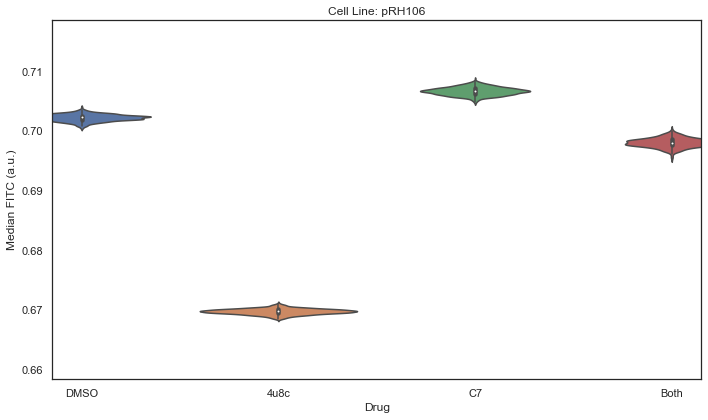

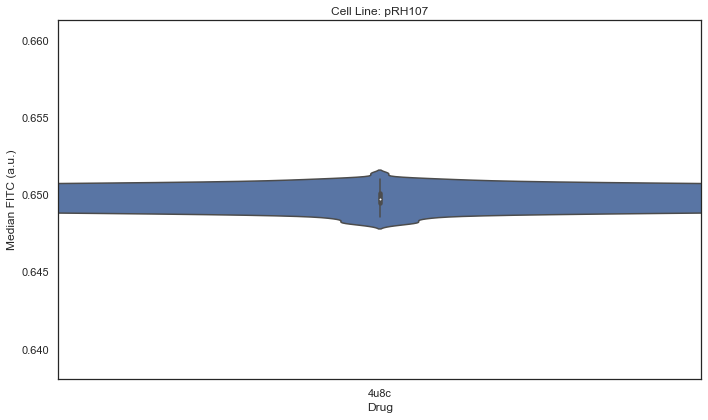

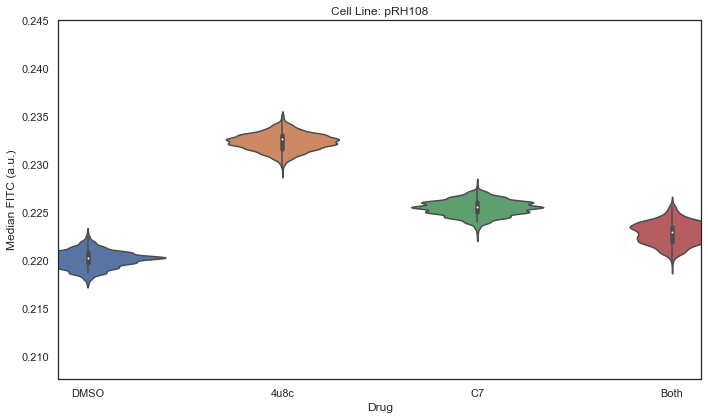

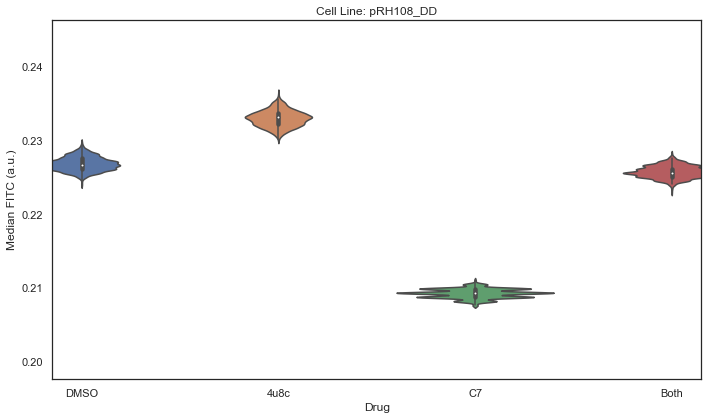

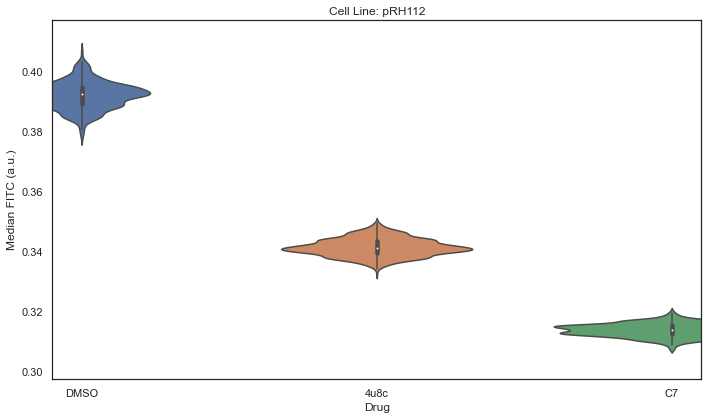

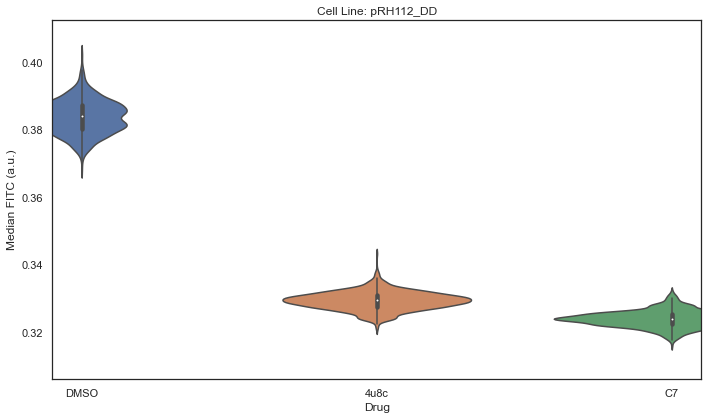

In [188]:
# Setting Seaborn style
sns.set(style="white")

# Preparing data for plotting bootstrapped medians
plot_data = []
for (cell_line, drug), medians in bootstrapped_results.items():
    for median in medians:
        plot_data.append({'Cell Line': cell_line, 'Drug': drug, 'Median': median})

df_plot = pd.DataFrame(plot_data)

# Preparing data for plotting MAD values
mad_data = []
for (cell_line, drug), mad in mad_results.items():
    mad_data.append({'Cell Line': cell_line, 'Drug': drug, 'MAD': mad})

df_mad = pd.DataFrame(mad_data)

# Unique cell lines
cell_lines = sorted(set(df_plot['Cell Line']))

# Define a color palette
palette = sns.color_palette("deep")

# Loop over each cell line to create a separate plot
for cell_line in cell_lines:
    plt.figure(figsize=(10, 6))
    ax = sns.violinplot(x='Drug', y='Median', data=df_plot[df_plot['Cell Line'] == cell_line], palette=palette)
    plt.title(f'Cell Line: {cell_line}', pad=5)
    plt.xlabel('Drug')
    plt.ylabel('Median FITC (a.u.)')

    # Plotting MAD values
    for index, row in df_mad[df_mad['Cell Line'] == cell_line].iterrows():
        plt.scatter(x=row['Drug'], y=row['MAD'], color='red', zorder=2)

    # Calculate min and max of the 'Median' values for the current cell line
    cell_line_data = df_plot[df_plot['Cell Line'] == cell_line]['Median']
    min_val, max_val = cell_line_data.min(), cell_line_data.max()
    plt.ylim(min_val - 0.01, max_val + 0.01)  # Set y-axis limits
    plt.xticks()

    plt.tight_layout()

    # Save the plot as a PNG file
    #plt.savefig(f'{cell_line}_violinplot.png', bbox_inches='tight', format='png', dpi=600)

    plt.show()

    plt.close()

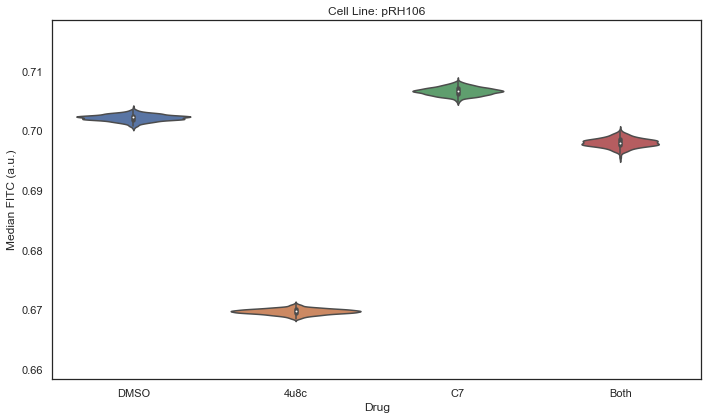

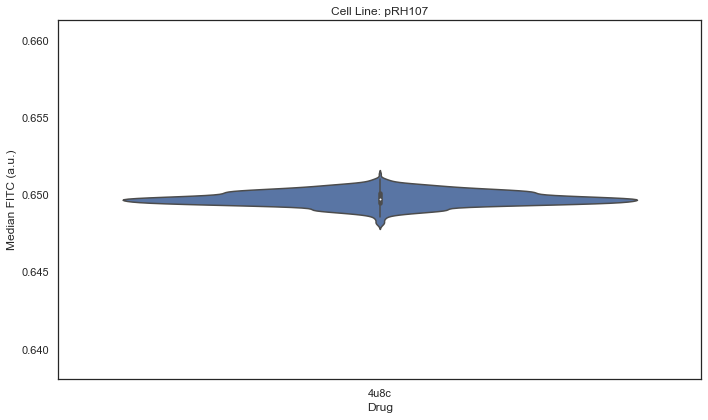

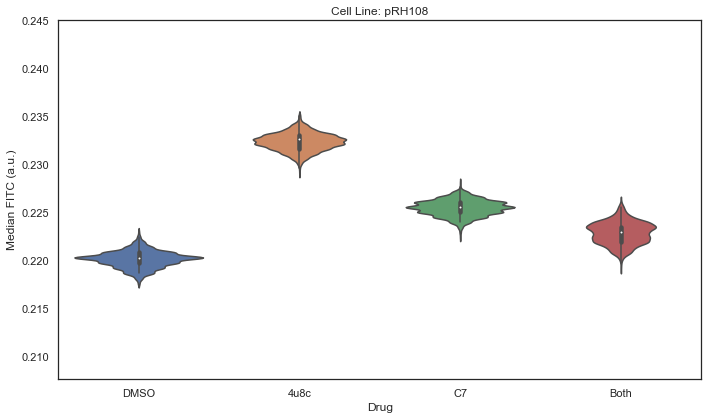

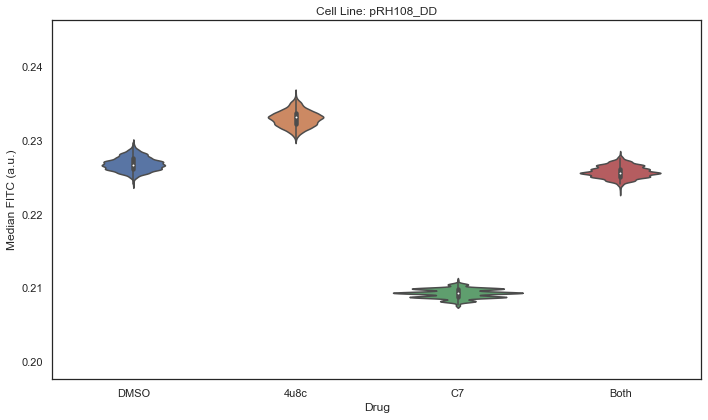

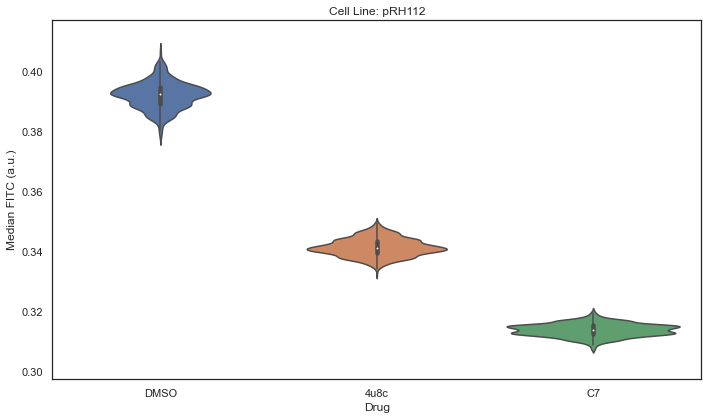

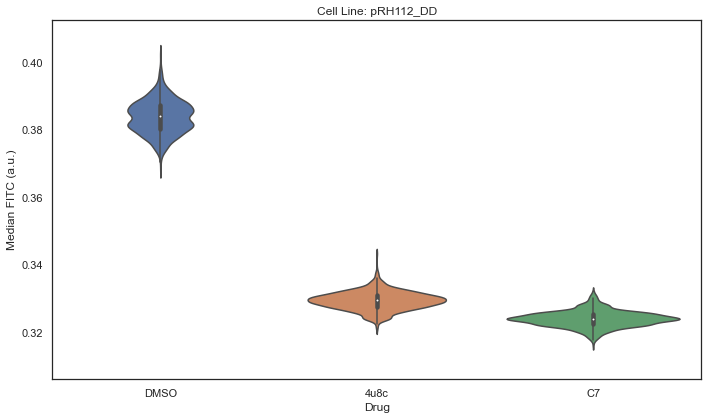

In [19]:
# Setting Seaborn style
sns.set(style="white")

# Preparing data for plotting
plot_data = []
for (cell_line, drug), medians in bootstrapped_results.items():
    for median in medians:
        plot_data.append({'Cell Line': cell_line, 'Drug': drug, 'Median': median})

df_plot = pd.DataFrame(plot_data)

# Unique cell lines
cell_lines = sorted(set(df_plot['Cell Line']))

# Define a color palette
palette = sns.color_palette("deep")

# Loop over each cell line to create a separate plot
for cell_line in cell_lines:
    plt.figure(figsize=(10, 6))
    ax = sns.violinplot(x='Drug', y='Median', data=df_plot[df_plot['Cell Line'] == cell_line],palette=palette)
    plt.title(f'Cell Line: {cell_line}', pad=5)
    plt.xlabel('Drug')
    plt.ylabel('Median FITC (a.u.)')
    
    # Calculate min and max of the 'Median' values for the current cell line
    cell_line_data = df_plot[df_plot['Cell Line'] == cell_line]['Median']
    min_val, max_val = cell_line_data.min(), cell_line_data.max()
    plt.ylim(min_val - 0.01, max_val + 0.01)  # Set y-axis limits
    #plt.yscale('log') 
    #plt.ylim(0.2,0.72)
    plt.xticks()

    plt.tight_layout()
    
    # Save the plot as a PNG file
    #plt.savefig(f'{cell_line}_violinplot.png', bbox_inches='tight', format='png', dpi=600)
    
    plt.show()
    
    plt.close()


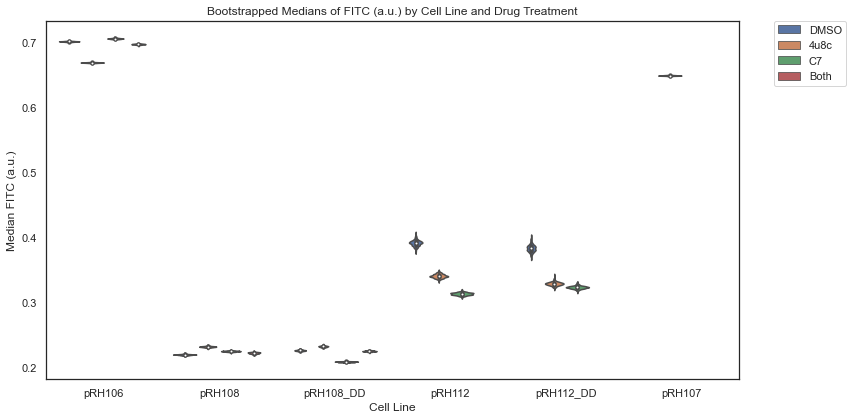

In [196]:
# Preparing data for plotting
plot_data = []
for (cell_line, drug), medians in bootstrapped_results.items():
    for median in medians:
        plot_data.append({'Cell Line': cell_line, 'Drug': drug, 'Median FITC (a.u.)': median})

df_plot = pd.DataFrame(plot_data)

# Creating box plots using Seaborn
plt.figure(figsize=(12, 6))
sns.violinplot(x='Cell Line', y='Median FITC (a.u.)', hue='Drug', data=df_plot, width=0.8)
plt.title('Bootstrapped Medians of FITC (a.u.) by Cell Line and Drug Treatment')

#plt.yscale('log') 

# Moving the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


plt.tight_layout()
    
#plt.savefig('Compiled_violinplots.png', bbox_inches='tight', format='png', dpi=600)
      
plt.show()
    
plt.close()


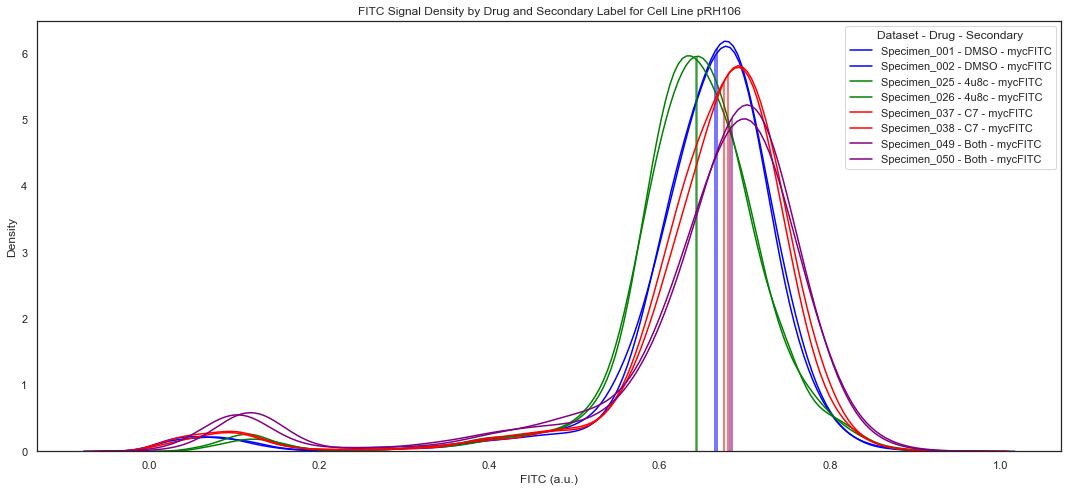

In [21]:
#adds a median line

def plot_kde_fitc_by_drug_secondary(data_dict, cell_line_label, antibody):
    plt.figure(figsize=(15, 7))

    # Define a color palette for the drugs
    drug_colors = {'DMSO': 'blue', '4u8c': 'green', 'C7': 'red', 'Both': 'purple'}

    for key, df in data_dict.items():
        # Filter for 'cell_line' label
        filtered_df = df[df['cell_line'] == cell_line_label]

        if not filtered_df.empty:
            for drug in drug_colors.keys():
                drug_df = filtered_df[filtered_df['drug'] == drug]
                for secondary_label in drug_df['secondary'].unique():
                    sec_df = drug_df[drug_df['secondary'] == secondary_label]
                    if not sec_df.empty:
                        label = f'{key} - {drug} - {secondary_label}'
                        linestyle = '--' if secondary_label == 'unlabel' else '-'
                        
                        # Plot the KDE
                        sns_kde = sns.kdeplot(data=sec_df, x=antibody, label=label, 
                                              fill=False, color=drug_colors[drug], linestyle=linestyle)

                        # Calculate and plot the median line up to the KDE curve
                        median_value = sec_df[antibody].median()
                        kde_values = sns_kde.get_lines()[-1].get_data()
                        kde_x, kde_y = kde_values
                        median_density = np.interp(median_value, kde_x, kde_y)
                        plt.plot([median_value, median_value], [0, median_density], color=drug_colors[drug], linestyle=linestyle, alpha=0.7)

    plt.xlabel('FITC (a.u.)')
    #plt.xlim(-0.1,1)
    plt.ylabel('Density')
    plt.title('FITC Signal Density by Drug and Secondary Label for Cell Line {}'.format(cell_line_label))
    plt.legend(title='Dataset - Drug - Secondary')
    plt.tight_layout()
    
    # Uncomment to save the figure
    #plt.savefig(f'{cell_line}_violinplot.png', bbox_inches='tight', format='png', dpi=600)

# Example usage
plot_kde_fitc_by_drug_secondary(labeled_data_dict, 'pRH106', 'mCherry (a.u.)')


In [169]:
# Initialize a dictionary to keep track of the counts
replicate_counts = {}

for key, df in labeled_data_dict.items():
    # Parse the cell_line and drug from the key or any other method
    cell_line = df['cell_line'].iloc[0]
    drug = df['drug'].iloc[0]
    
    # Create a unique key for the cell_line and drug combination
    unique_key = (cell_line, drug)
    
    # If the combination is not in the dictionary, add it and assign 'replicate 1'
    if unique_key not in replicate_counts:
        replicate_counts[unique_key] = 1
        df['replicate'] = 'replicate 1'
    # Otherwise, assign 'replicate 2' and reset the count for the next pair of DataFrames
    else:
        df['replicate'] = 'replicate 2'
        del replicate_counts[unique_key]  # Reset for the next pair if more than 2


# Now combine all the dataframes into one
combined_df = pd.concat(labeled_data_dict.values(), ignore_index=True)
        
simplified_df = combined_df[['cell_line','drug','FITC (a.u.)','replicate']]

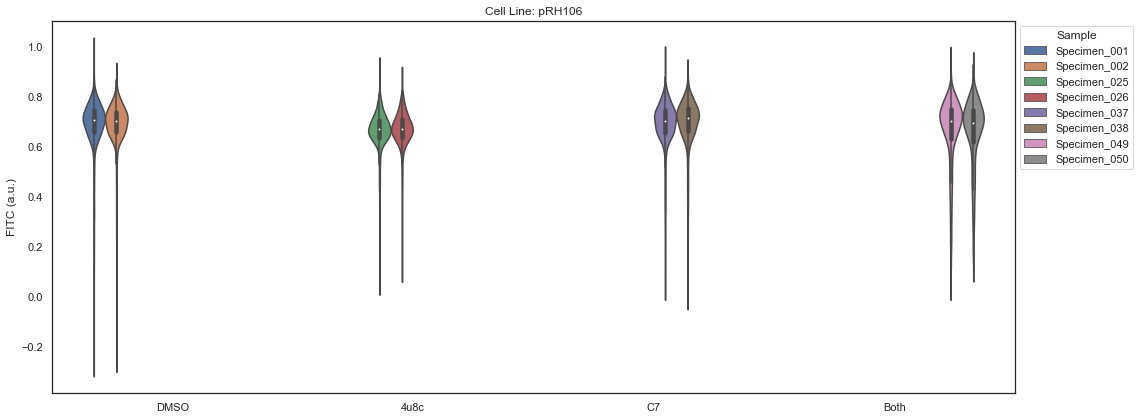

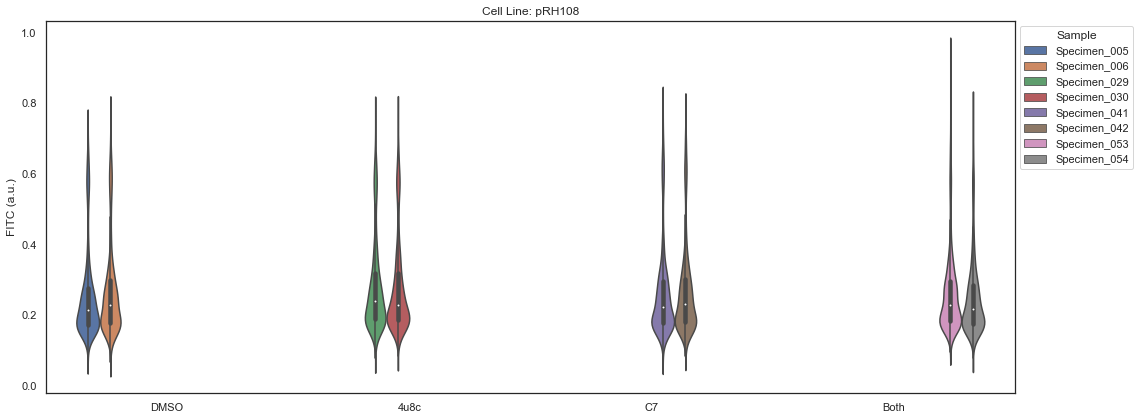

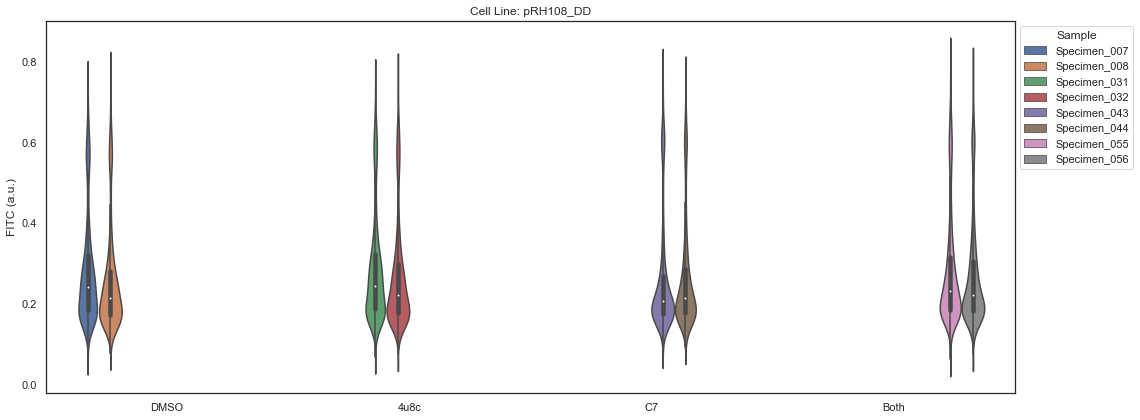

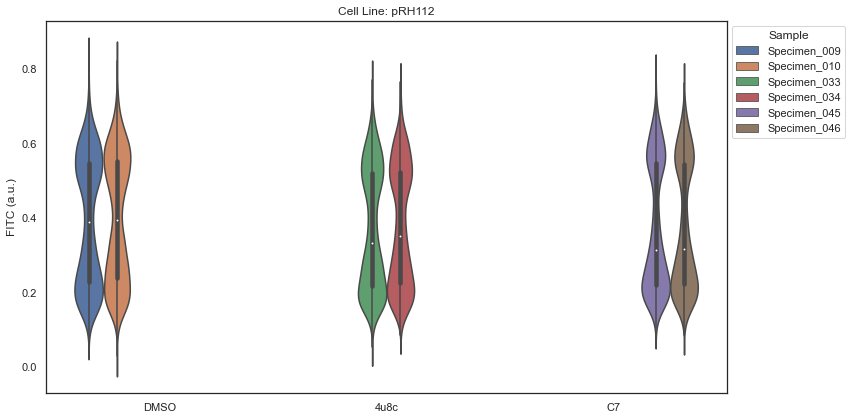

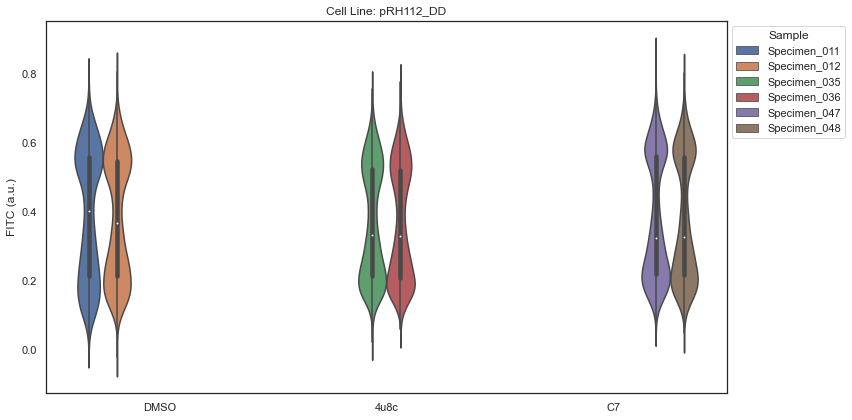

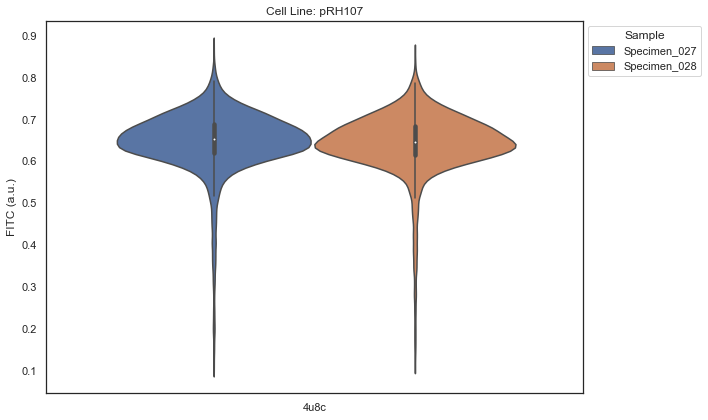

In [22]:
# Combine all the dataframes in labeled_data_dict into a single dataframe
combined_df = pd.concat(labeled_data_dict.values(), ignore_index=True)

# Extract unique cell lines
cell_lines = combined_df['cell_line'].unique()

# Base width per drug condition
base_width_per_drug = 4  # Adjusted for wider box plots

for cell_line in cell_lines:
    # Determine the number of unique drug conditions for the cell line
    num_drugs = combined_df[combined_df['cell_line'] == cell_line]['drug'].nunique()

    # Calculate the plot width dynamically, slightly increased
    plot_width = max(10, base_width_per_drug * num_drugs)  # Ensures a minimum width

    # Create figure with dynamic width
    plt.figure(figsize=(plot_width, 6))  # Adjusted height for layout

    # Filter the dataframe for the current cell line
    df_cell_line = combined_df[combined_df['cell_line'] == cell_line]

    # Create the box plot with increased bar width
    ax = sns.violinplot(x='drug', y='FITC (a.u.)', hue='sample_name', dodge=True, data=df_cell_line, width=0.75)  # Increased box width

    # Set plot title and labels
    plt.title(f'Cell Line: {cell_line}')
    plt.xlabel('', labelpad=0)
    plt.ylabel('FITC (a.u.)')

    # Center the x-axis label
    ax.xaxis.set_label_coords(0.5, -0.2)  # Adjust for centering

    # Adjust legend to be outside the plot
    plt.legend(title='Sample', loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    
    plt.savefig(f'{cell_line}_violinplot_raw.png', bbox_inches='tight', format='png', dpi=300)
    
    plt.show()
    
    plt.close()


/var/folders/sv/w2n5lcb57zz70hk1l6tkkkf00000gp/T/ipykernel_3338/516406574.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simplified_df['category'] = simplified_df['cell_line'] + '_' + simplified_df['drug']


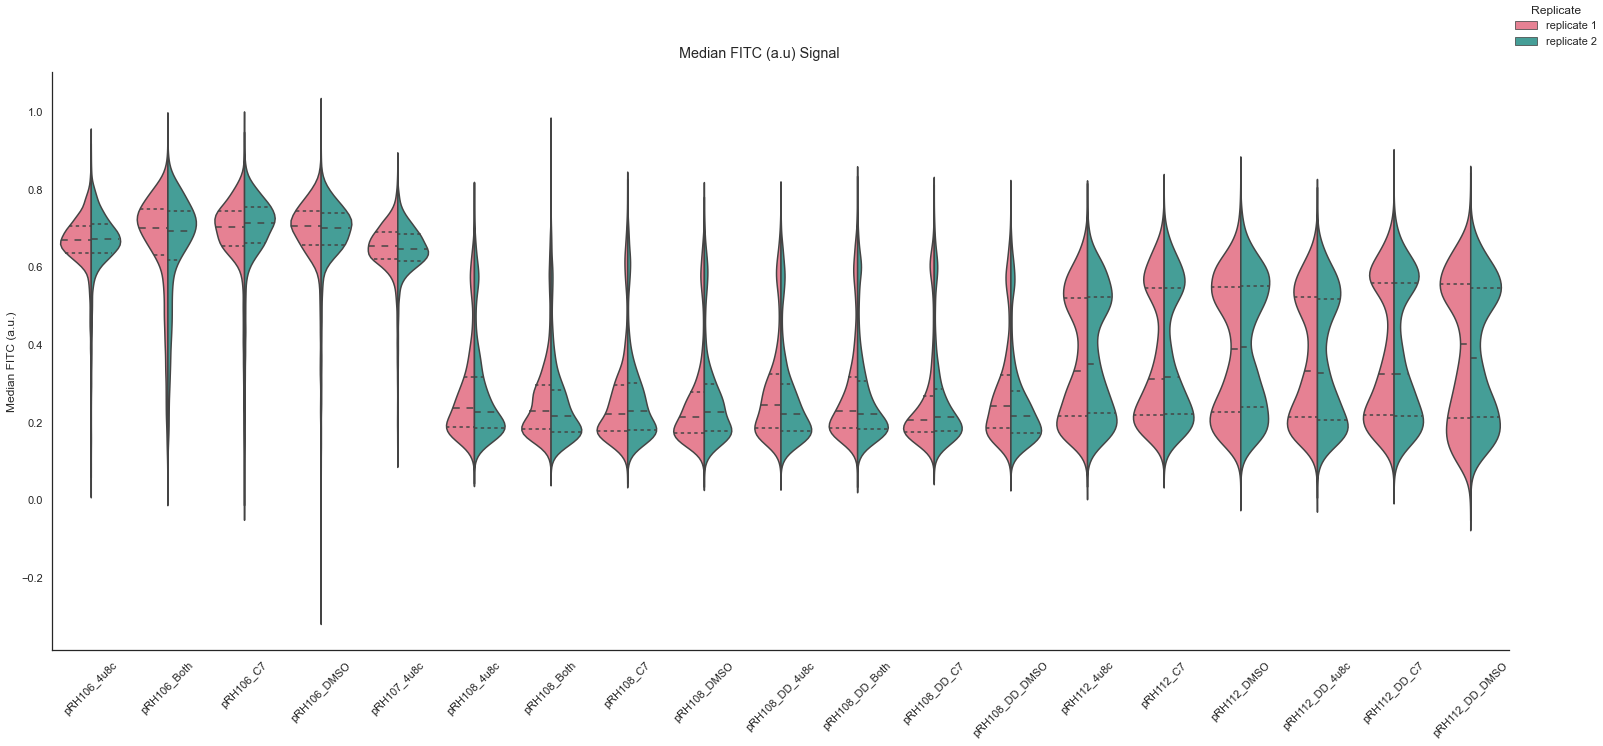

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your DataFrame is named simplified_df
# Create a new column combining 'cell_line' and 'drug'
simplified_df['category'] = simplified_df['cell_line'] + '_' + simplified_df['drug']

# Get the unique categories that actually have data
valid_categories = simplified_df['category'].unique()

# Custom sorting function
def custom_sort(category):
    parts = category.split('_')
    cell_line = '_'.join(parts[:-1])  # Handle cell_line names with underscores
    drug = parts[-1]
    return (cell_line, drug)

sorted_categories = sorted(valid_categories, key=custom_sort)

# Plotting using catplot
g = sns.catplot(
    x='category', 
    y='FITC (a.u.)', 
    hue='replicate',
    data=simplified_df, 
    kind='violin',
    split=True,
    inner="quartile",
    palette="husl",
    order=sorted_categories,  # Use the custom sorted category order
    height=10, aspect=2  # Adjust the size of the plot
)

# Customizing the plot
g.fig.suptitle('Median FITC (a.u) Signal')
g.set_axis_labels('', 'Median FITC (a.u.)')
plt.xticks(rotation=45)

# Adjust the legend to be outside the plot
g._legend.set_title('Replicate')
g._legend.set_bbox_to_anchor((1.05, 1))

plt.tight_layout()

g.savefig("combined_violin_plot.png", dpi=300, bbox_inches='tight')

plt.show()
